# Dataset 2: California Housing - Venkateshwaran

In [317]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,accuracy_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import plotly.express as px
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")


## Data Preprocessing

Load and explore each dataset.

Identify missing values and assess their distribution.

In [318]:
housing = fetch_california_housing(as_frame=True)
housing_df= housing.frame
housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [319]:
housing_df.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

### Understanding the distribution of Data across features

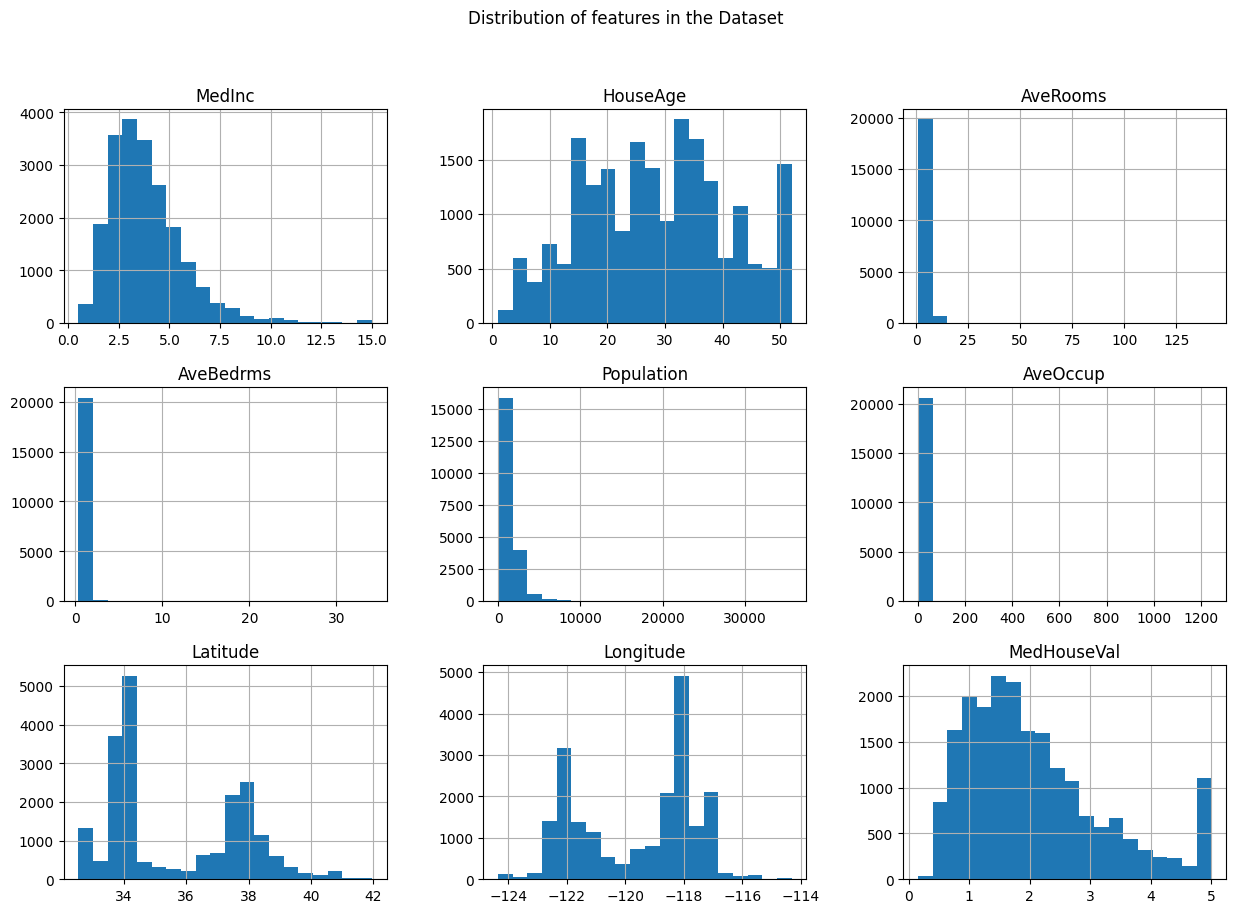

In [320]:
housing_df.hist(figsize=(15, 10), bins=20)
plt.suptitle("Distribution of features in the Dataset")
plt.show()

### Understanding the outliers of Data across features through Box Plots

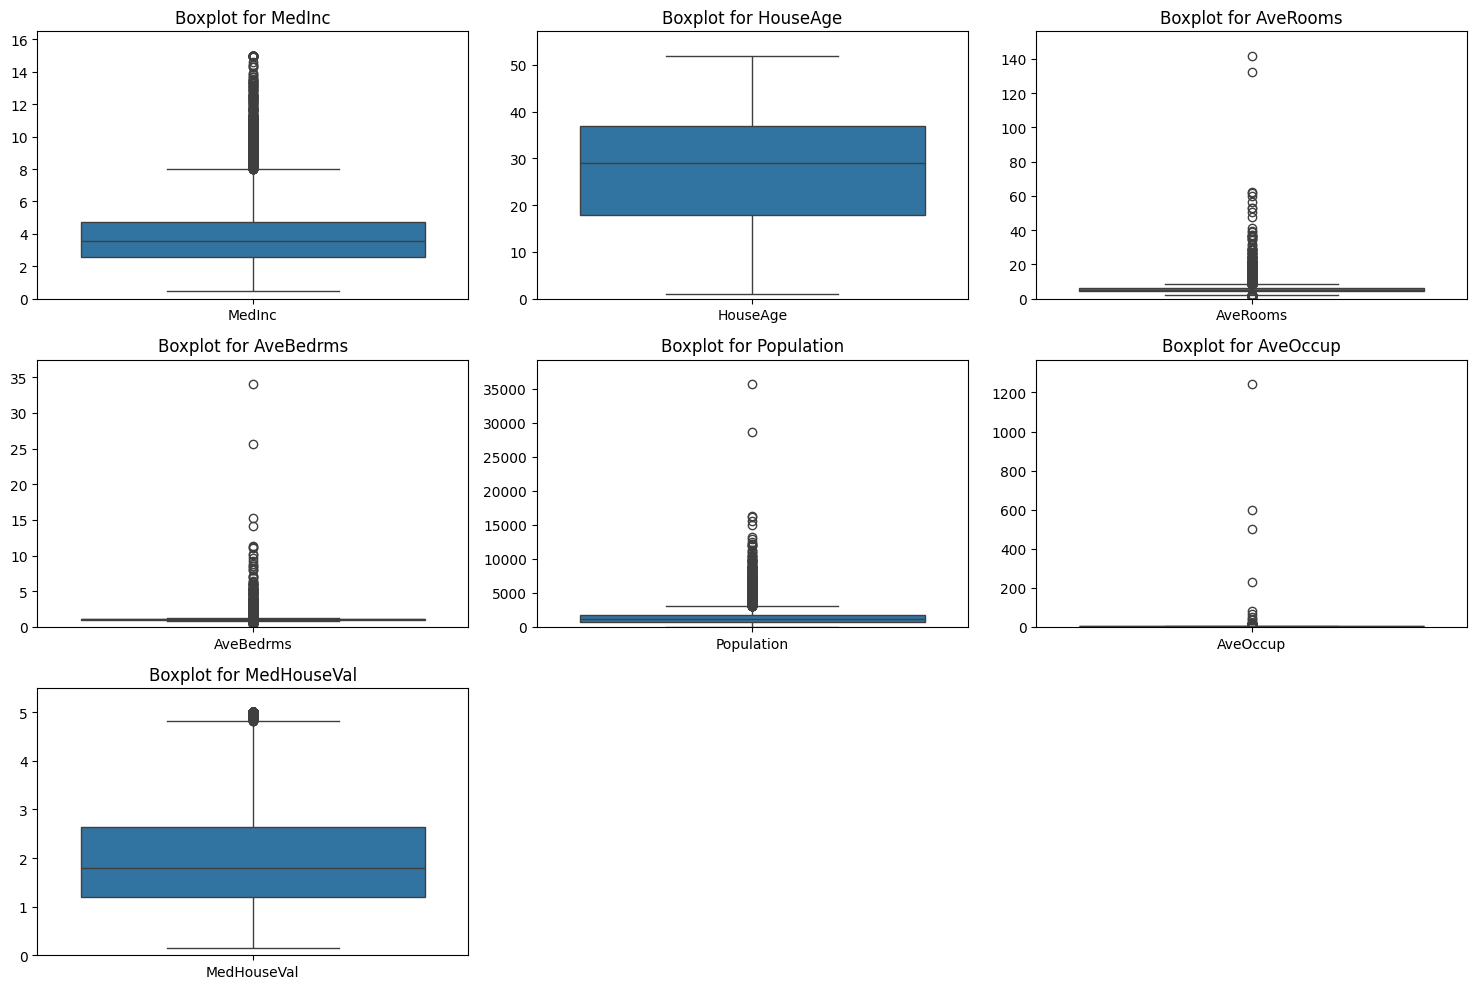

In [ ]:
housing_boxplot = housing_df[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'MedHouseVal']]

# Function to plot side-by-side box plots with specific y-limits based on data
def plot_side_by_side_boxplots(data, columns):
    n_cols = 3  # Number of columns for the subplots
    n_rows = (len(columns) + n_cols - 1) // n_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

    for i, col in enumerate(columns):
        row, col_index = divmod(i, n_cols)
        sns.boxplot(ax=axes[row, col_index], data=data[[col]])
        axes[row, col_index].set_title(f"Boxplot for {col}")
        y_limit = data[col].max() * 1.1  # Set y-limit to 110% of the max value
        axes[row, col_index].set_ylim(0, y_limit)

    # Remove empty subplots if any
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

# Plot side-by-side box plots for each numerical feature
plot_side_by_side_boxplots(housing_boxplot, housing_boxplot.columns)

### Generate Nulls Randomly

Since original data frame doesnot have any Null values, to demonstrate the imputation technique introducing nulls on HouseAge and Population columns randomly and Proceed with Verifying the Accuracy of it

In [ ]:
# Introduction of Missing Values in Data Frame
np.random.seed(42)
missingness_percentage_houseage = 0.1
missingness_percentage_population = 0.2

# Store original non-missing values for later comparison
original_values = housing_df[['HouseAge', 'Population']].copy()

missing_indices_houseage = np.random.choice(housing_df.index, size=int(missingness_percentage_houseage * len(housing_df)), replace=False)
housing_df.loc[missing_indices_houseage, 'HouseAge'] = np.nan

missing_indices_population = np.random.choice(housing_df.index, size=int(missingness_percentage_population * len(housing_df)), replace=False)
housing_df.loc[missing_indices_population, 'Population'] = np.nan

# Check for missing values
print("Missing values after introducing NaNs:\n", housing_df.isnull().sum())


Missing values after introducing NaNs:
 MedInc            0
HouseAge       2064
AveRooms          0
AveBedrms         0
Population     2064
AveOccup          0
Latitude          0
Longitude         0
MedHouseVal       0
dtype: int64


In [323]:
housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,NaN,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
df=housing_df

# Evaluate RMSE for numerical variables
def calculate_rmse(original_data, imputed_data, target_column, missing_indices):
    #Identifying the original value and the imputed value
    true_values = original_data.loc[missing_indices, target_column]
    imputed_values = imputed_data.loc[missing_indices, target_column]
    rmse = np.sqrt(mean_squared_error(true_values, imputed_values))
    return rmse

# Visual comparison using histograms and box plots
def plot_comparison(imputed_df, original_df, col, method):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)   
    plt.ylim(0, 250) # Set y-axis limits from 0 to 200 
    sns.histplot(original_df[col], color='blue', kde=True, label='Original')
    sns.histplot(imputed_df[col], color='red', kde=True, label='Imputed')
    plt.title(f'Histogram Comparison: {col} ({method})')
    plt.tight_layout()
    
    plt.legend()
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data={'Original': original_df[col], 'Imputed': imputed_df[col]}, palette='Set2')
    y_limit = max(original_df[col].max(), imputed_df[col].max()) * 1.1  # Calculate y-limit based on max value
    plt.ylim(0, y_limit)
    plt.xticks([0, 1], ['Original', 'Imputed'])
    plt.title(f'Box Plot Comparison: {col} ({method})')
    plt.tight_layout()
    plt.show()

## Imputation Techniques: Regression Imputation

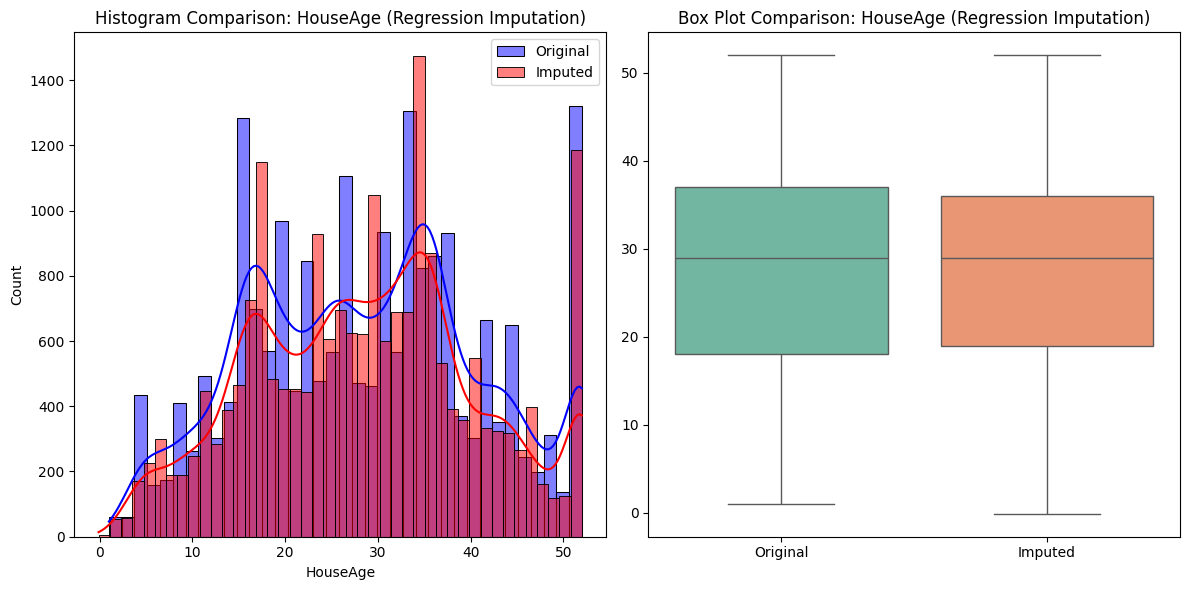

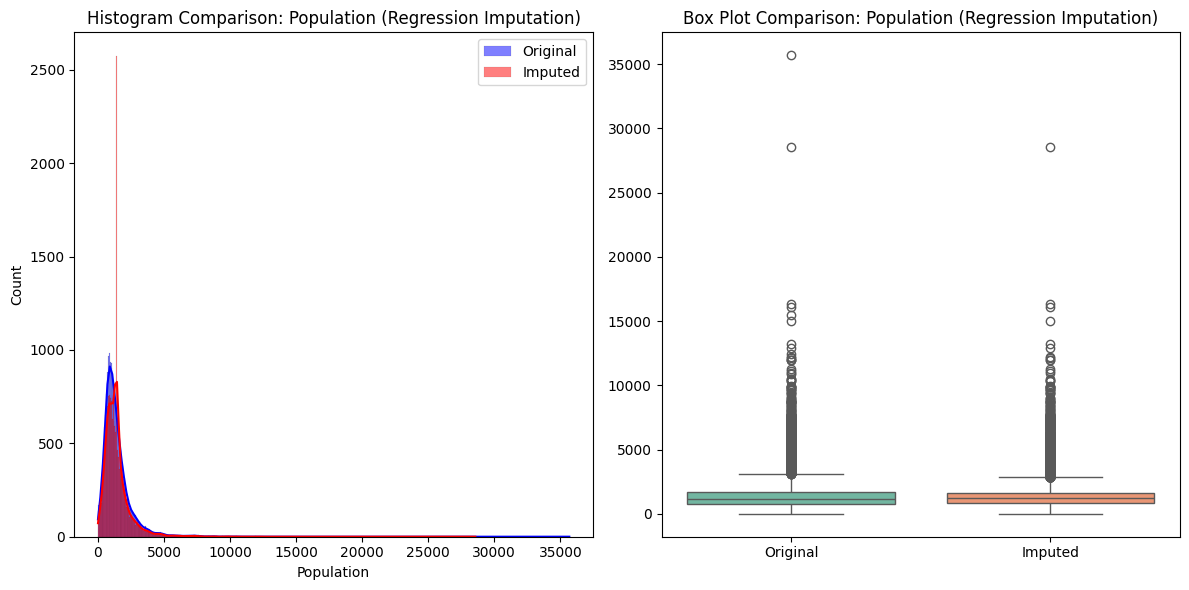

RMSE for HouseAge (Regression Imputation): 11.17227764336804
RMSE for Population (Regression Imputation): 1413.8176445452134


In [ ]:
df=housing_df
# Function to perform regression imputation
def regression_imputation(df, target_col):
    imputer = SimpleImputer(strategy='mean')
    non_target_cols = df.drop(columns=[target_col]).columns
    df[non_target_cols] = imputer.fit_transform(df[non_target_cols])
    
    train_df = df[df[target_col].notna()]
    test_df = df[df[target_col].isna()]
    
    if len(train_df) == 0 or len(test_df) == 0:
        return df
    
    X_train = train_df.drop(columns=[target_col])
    y_train = train_df[target_col]
    model = LinearRegression().fit(X_train, y_train)
    
    X_test = test_df.drop(columns=[target_col])
    predicted_values = model.predict(X_test)
    df.loc[df[target_col].isna(), target_col] = predicted_values
    
    return df

# Apply regression imputation for "HouseAge" and "Population"
df_reg = regression_imputation(df.copy(), 'HouseAge')
df_reg = regression_imputation(df_reg, 'Population')


# Visual comparison using histograms and box plots
def plot_comparison(imputed_df, original_df, col, method):

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)   
    sns.histplot(original_df[col], color='blue', kde=True, label='Original')
    sns.histplot(imputed_df[col], color='red', kde=True, label='Imputed')    
    plt.title(f'Histogram Comparison: {col} ({method})')
    plt.tight_layout()
    plt.legend()
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data={'Original': original_df[col], 'Imputed': imputed_df[col]}, palette='Set2')
    plt.xticks([0, 1], ['Original', 'Imputed'])
    plt.title(f'Box Plot Comparison: {col} ({method})')
    plt.tight_layout()
    plt.show()
# Plot comparisons
plot_comparison(df_reg, original_values, 'HouseAge', 'Regression Imputation')
plot_comparison(df_reg, original_values, 'Population', 'Regression Imputation')

rmse_houseage_reg = calculate_rmse(df_reg, original_values, 'HouseAge',missing_indices_houseage)
rmse_population_reg = calculate_rmse(df_reg, original_values, 'Population',missing_indices_population)
print("RMSE for HouseAge (Regression Imputation):", rmse_houseage_reg)
print("RMSE for Population (Regression Imputation):", rmse_population_reg)



## Imputation Techniques: KNN Imputation

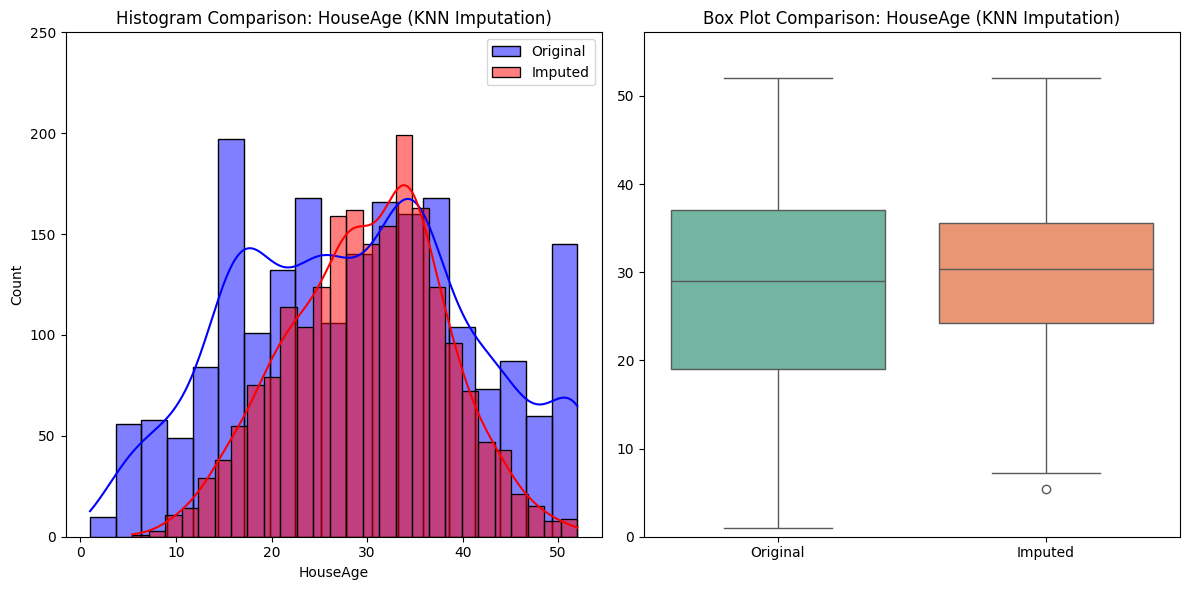

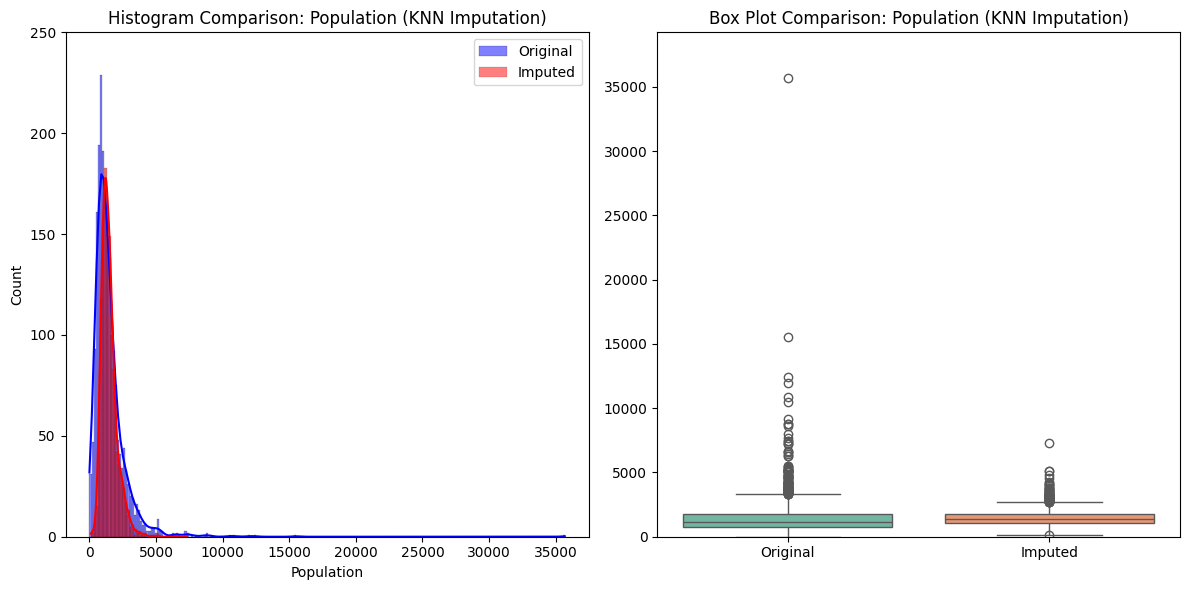

RMSE for HouseAge (KNN Imputation): 10.752223494585637
RMSE for Population (KNN Imputation): 1371.5637782015165


In [326]:
# Apply KNN imputation
knn_imputer = KNNImputer(n_neighbors=5)
df_knn = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns)

rmse_houseage_knn = calculate_rmse(df_knn, original_values, 'HouseAge',missing_indices_houseage)
rmse_population_knn = calculate_rmse(df_knn, original_values, 'Population',missing_indices_population)

#Plot Comparisons
plot_comparison(df_knn.loc[missing_indices_houseage], original_values.loc[missing_indices_houseage], 'HouseAge', 'KNN Imputation')
plot_comparison(df_knn.loc[missing_indices_population], original_values.loc[missing_indices_population], 'Population', 'KNN Imputation')

print("RMSE for HouseAge (KNN Imputation):", rmse_houseage_knn)
print("RMSE for Population (KNN Imputation):", rmse_population_knn)



## Imputation Techniques: Iterative Imputation

RMSE for HouseAge (Iterative Imputation): 11.16145072728622
RMSE for Population (Iterative Imputation): 1347.7102535838915


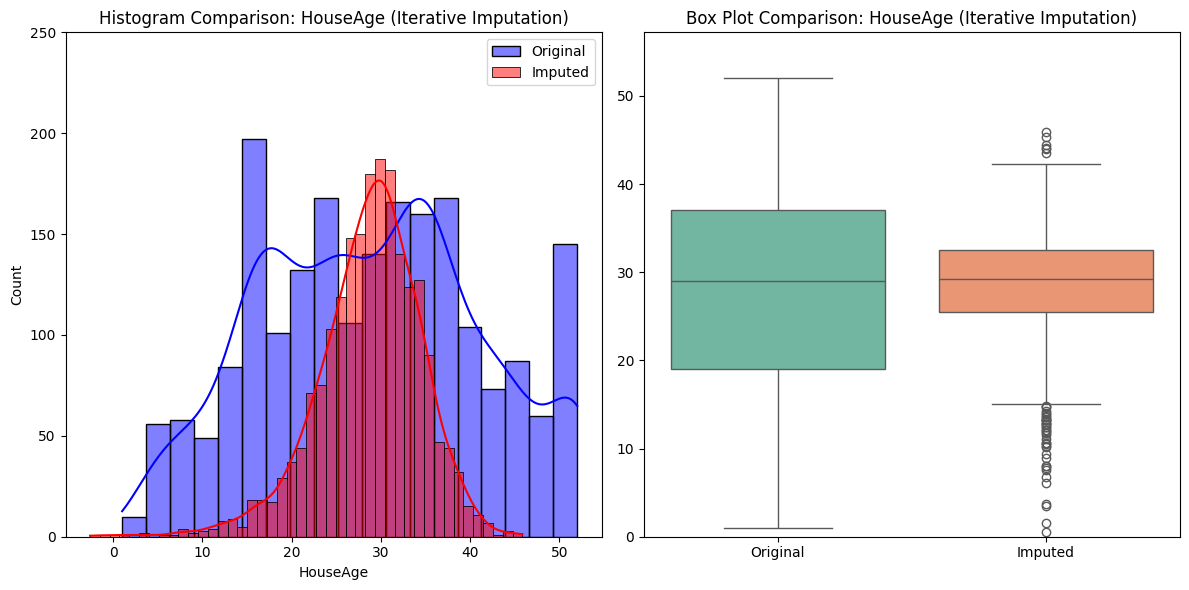

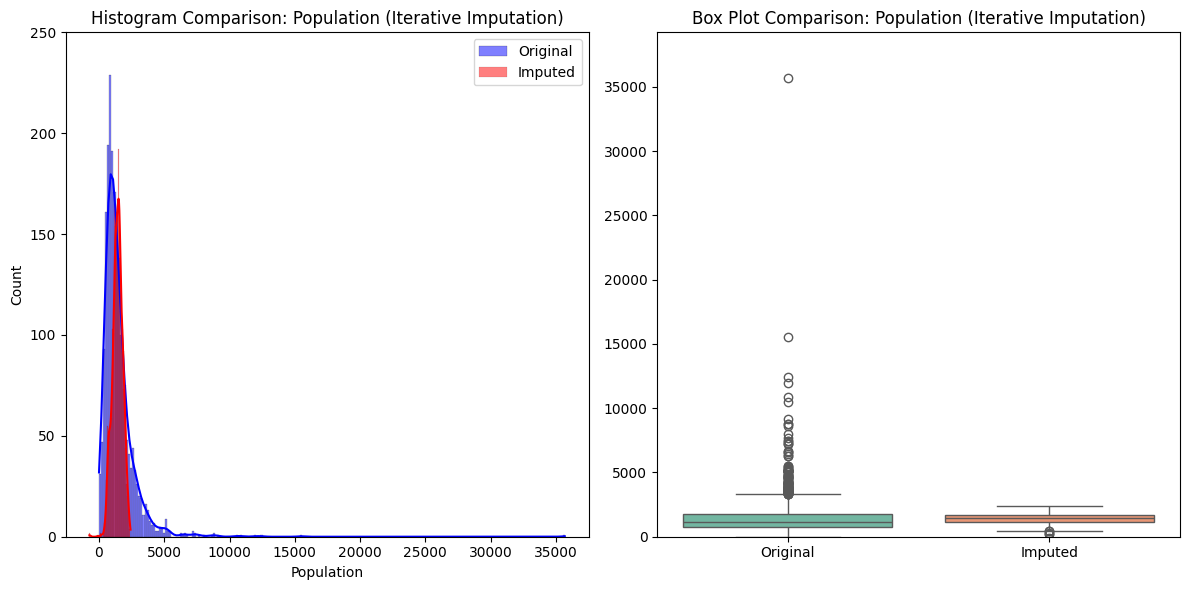

In [327]:
# Apply iterative imputation
iter_imputer = IterativeImputer(random_state=42)
df_iter = pd.DataFrame(iter_imputer.fit_transform(df), columns=df.columns)

rmse_houseage_iter = calculate_rmse(df_iter, original_values, 'HouseAge',missing_indices_houseage)
rmse_population_iter = calculate_rmse(df_iter, original_values, 'Population',missing_indices_population)

print("RMSE for HouseAge (Iterative Imputation):", rmse_houseage_iter)
print("RMSE for Population (Iterative Imputation):", rmse_population_iter)

plot_comparison(df_iter.loc[missing_indices_houseage], original_values.loc[missing_indices_houseage], 'HouseAge', 'Iterative Imputation')
plot_comparison(df_iter.loc[missing_indices_population], original_values.loc[missing_indices_population], 'Population', 'Iterative Imputation')

## Imputation Method Comparison (Based on RMSE)

### RMSE Results:
- **HouseAge (Regression Imputation):** 11.1723  
- **Population (Regression Imputation):** 1413.8176  
- **HouseAge (KNN Imputation):** 10.7522  
- **Population (KNN Imputation):** 1371.5638  
- **HouseAge (Iterative Imputation):** 11.1615  
- **Population (Iterative Imputation):** 1347.7103  

### Analysis:

#### **HouseAge:**
- **KNN Imputation** has the lowest RMSE (10.75), making it the best performer.
- **Iterative (11.16) and Regression (11.17)** perform similarly but worse than KNN.

#### **Population:**
- **Iterative Imputation** has the lowest RMSE (1347.71), making it the best approach.
- **KNN follows closely** (1371.56).
- **Regression Imputation performs the worst** (1413.82).

### **Conclusion:**
The results indicate that no single imputation method performs best across all variables, emphasizing the importance of selecting techniques based on the specific characteristics of each feature. For HouseAge, KNN Imputation yields the lowest RMSE (10.75), suggesting that leveraging similar data points through nearest neighbors provides the most accurate estimations. In contrast, for Population, Iterative Imputation achieves the best performance with the lowest RMSE (1347.71), likely due to its ability to model complex interdependencies across multiple variables. Regression Imputation is outperformed by both methods for both variables, implying that a simple linear approach may not effectively capture the underlying data patterns. These findings suggest that applying different imputation methods to different variables, rather than enforcing a uniform approach, can enhance the accuracy and reliability of missing data estimations.

## Impact on Predictive Modeling

Train a Random Forest classifier/regressor on the original dataset (with missing values dropped).
Train the model again using each of the imputed datasets.

Compare model performance (accuracy/RMSE) across different imputation methods.

RMSE (Original Dataset): 0.5046540489138713
RMSE (Regression Imputation): 0.5293581753134404
RMSE (KNN Imputation): 0.5110356213295639
RMSE (Iterative Imputation): 0.5313687863366439


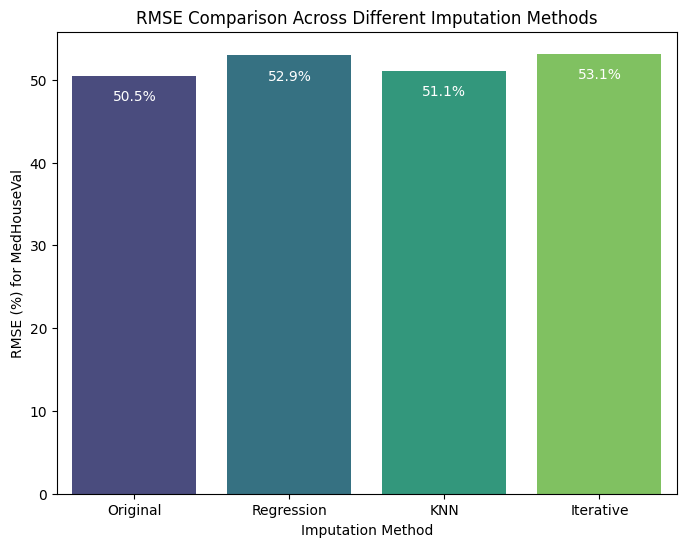

In [330]:
# Function to train and evaluate Random Forest regressor
def evaluate_random_forest(df, target_col='MedHouseVal'):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# Evaluate model performance on the original dataset
rmse_original = evaluate_random_forest(df_original)

# Evaluate model performance on the imputed datasets
rmse_reg = evaluate_random_forest(df_reg)
rmse_knn = evaluate_random_forest(df_knn)
rmse_iter = evaluate_random_forest(df_iter)

# Print RMSE for each dataset
print("RMSE (Original Dataset):", rmse_original)
print("RMSE (Regression Imputation):", rmse_reg)
print("RMSE (KNN Imputation):", rmse_knn)
print("RMSE (Iterative Imputation):", rmse_iter)

# Visual comparison of RMSE
imputation_methods = ['Original', 'Regression', 'KNN', 'Iterative']
# Convert RMSE values to percentages
rmse_percentages = [value * 100 for value in rmse_values]

plt.figure(figsize=(8, 6))
barplot = sns.barplot(x=imputation_methods, y=rmse_percentages, palette='viridis')

# Add data labels (percentages) inside the bars
for i, value in enumerate(rmse_percentages):
    plt.text(i, value - 3, f'{value:.1f}%', ha='center', color='white')  # Adjust position and color for visibility

plt.title('RMSE Comparison Across Different Imputation Methods')
plt.ylabel('RMSE (%) for MedHouseVal')
plt.xlabel('Imputation Method')
plt.show()

###  Insights:
1. **Original Dataset RMSE (0.5047)**  
   - This serves as the baseline. Any imputation method should ideally match or improve upon this value.  

2. **Regression Imputation RMSE (0.5294)**  
   - This method increases RMSE, suggesting that a linear approach does not fully capture the relationships in the data.  

3. **KNN Imputation RMSE (0.5110)**  
   - KNN performs the best among the imputation methods, as it is closest to the original dataset's RMSE.  
   
4. **Iterative Imputation RMSE (0.5314)**  
   - Highest RMSE among all methods, indicating it may introduce additional noise or inconsistencies in the imputed values.  

### **Conclusion:**
KNN Imputation emerges as the best method, as it results in the smallest increase in RMSE compared to the original dataset, indicating that it preserves data structure more effectively than other techniques. In contrast, Regression and Iterative Imputation perform worse, suggesting that these methods may introduce biases or fail to capture complex relationships within the data, potentially leading to overfitting. Notably, all imputation methods lead to an increase in RMSE, underscoring the impact of missing data handling on predictive accuracy. To further improve results, potential enhancements could include optimizing KNN parameters, exploring hybrid imputation techniques, or incorporating advanced feature engineering strategies. 


## Summary
As part of this analysis, the California Housing dataset was examined to assess the impact of different missing data imputation techniques on model performance. Three imputation methods—Regression, KNN, and Iterative—were applied to address missing values, and their effectiveness was evaluated using RMSE for features like HouseAge and Population, as well as for the target variable MedHouseVal with a Random Forest regressor. The results revealed that KNN Imputation was the most effective method, yielding the lowest RMSE for HouseAge and MedHouseVal, while Iterative Imputation performed best for Population. However, all imputation methods resulted in a higher RMSE than the original dataset, indicating that handling missing data can introduce some level of error. These findings suggest that further optimization, such as fine-tuning the imputation parameters or exploring hybrid imputation techniques, is necessary to minimize predictive accuracy loss.